# library

In [54]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [14]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [16]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# data loading

In [40]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

{}

In [41]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [42]:
!rm -rf chest_xray/

In [43]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images
!unzip labeled-chest-xray-images.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-26

# data preparation

In [44]:
import os
import shutil

# Direktori awal untuk train dan test
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"

# Direktori baru untuk dataset gabungan
combined_dir = "chest_xray/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# dataset checking

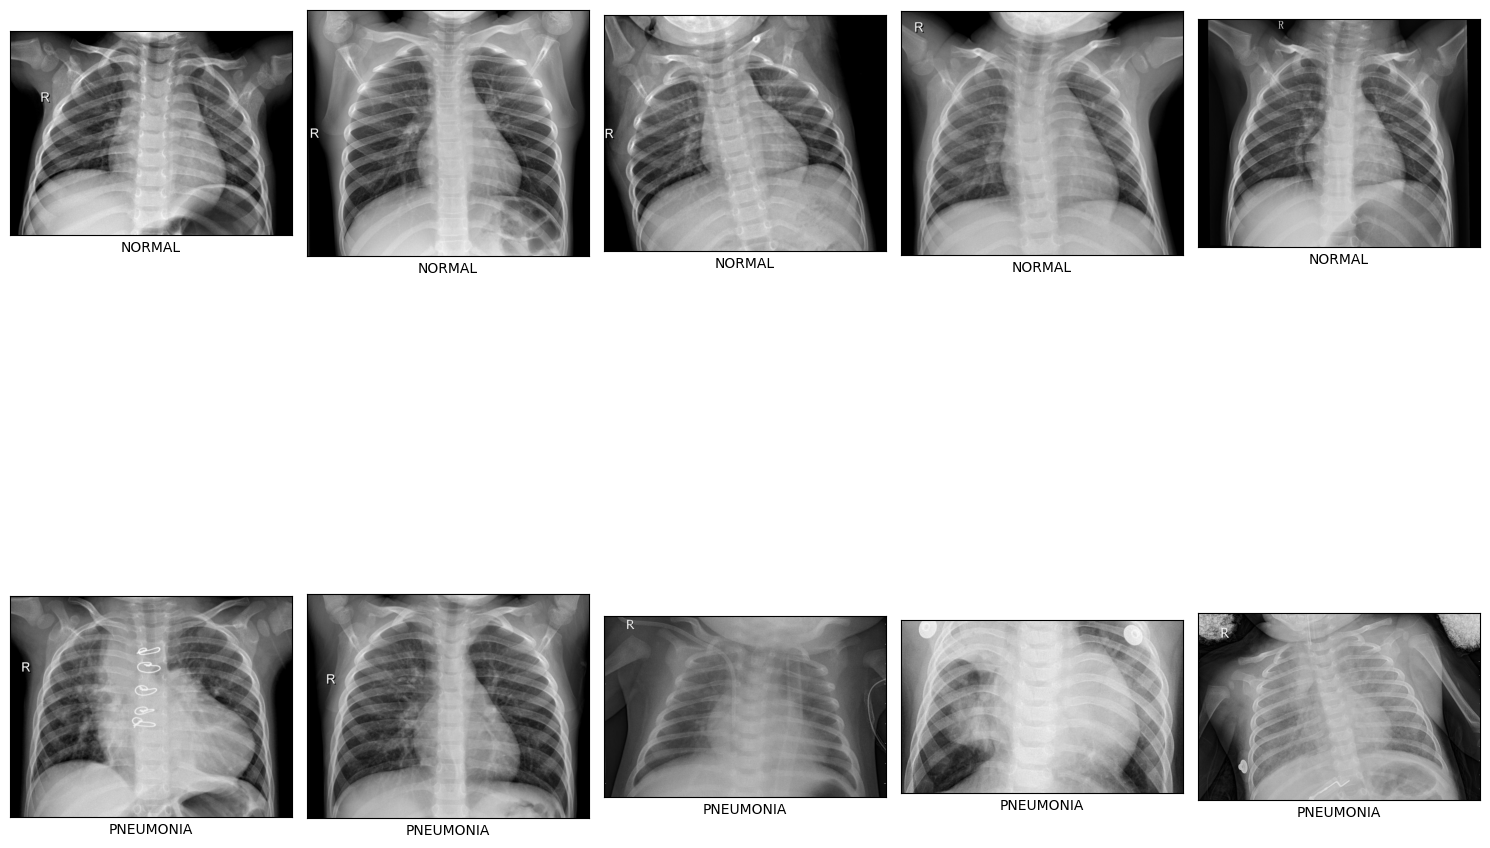

In [49]:
# membuat kamus yang menyimpan gambar setiap kelas data
lung_image = {}

# menentukan path sumber train
path = "chest_xray/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# menampilak nsecara acak 5 gambat di bawah setiap dari 2 kelas dari data
# akan melihat gambar yang berbeda setiap kode ini dijalankan
path_sub = "chest_xray/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

# plot distribusi


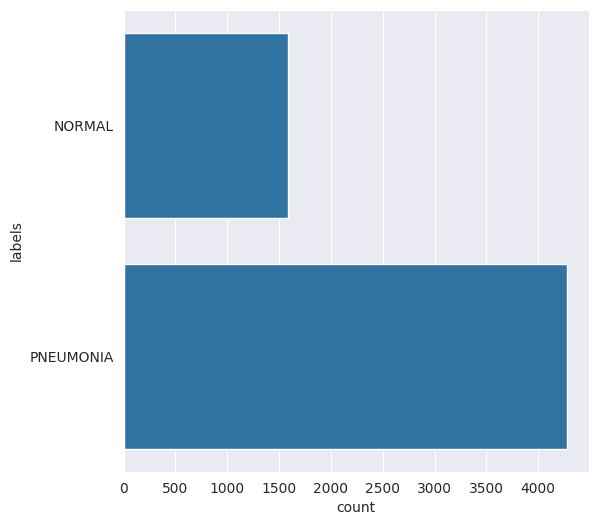

In [55]:
# definisikan path sumber
lung_path = "chest_xray/dataset/"

# membuat daftar yang menyimpan data untuk setiap nama file, path dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split("/")[-1])
        file_name.append(name)

# mendistribusikan kedalam dataframe
distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# plot distribusi
Label = distribution_train['labels']
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)
plt.show()


# data augmentation

In [57]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

Selanjutnya, kita menghasilkan gambar-gambar baru dengan menerapkan transformasi acak pada setiap gambar asli. Proses ini dilakukan hingga jumlah gambar yang dihasilkan mencapai target. Hasil dari augmentasi ini akan membantu memperluas dataset dengan variasi lebih banyak, yang dapat digunakan untuk melatih model lebih baik.

In [58]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path="chest_xray/dataset/NORMAL" # Path untuk gambar asli
augmented_path="chest_xray/dataset/NORMAL_augmented" # Path untuk gambar yang sudah diaugmentasi
images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi, jumlahnya disesuaikan sesuai kebutuhan
# Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate
images_to_generate=2000
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

Selanjutnya adalah visualisasi distribusi gambar-gambar pada setiap kelas dalam dataset. Pertama, kita mendefinisikan path sumber data. Lalu, kita membuat tiga list yang menyimpan nama file, path lengkap, dan label dari setiap gambar dalam dataset. Setelah itu, kita membuat dataframe dari ketiga list tersebut.

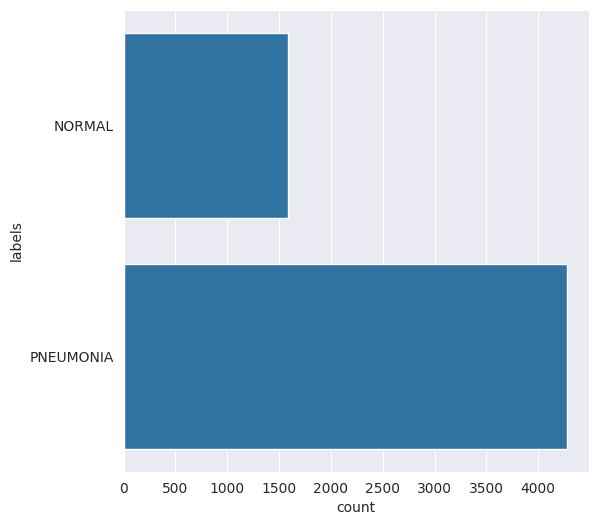

In [59]:
# Definisikan path sumber
lung_path = "chest_xray/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# data splitting

In [60]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'chest_xray/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
NORMAL,1583
PNEUMONIA,4273


Kemudian, kita menggunakan list tersebut untuk membuat dataframe yang rapi. Dataframe ini memudahkan kita untuk melihat jumlah data gambar pada setiap label. Dengan menggunakan groupby dan size, kita dapat melihat seberapa seimbang distribusi data dalam dataset berdasarkan label-label yang ada.

In [61]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [62]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

Pada tahap ini, kita menyatukan data path, label, dan keterangan set (train atau test) dalam dua dataframe terpisah. DataFrame df_tr akan berisi data pelatihan (train), sedangkan DataFrame df_te akan berisi data uji (test). Hal ini mempermudah kita untuk mengelola dan menganalisis data pada tahapan selanjutnya.

In [63]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "chest_xray/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels   
test   NORMAL        334
       PNEUMONIA     838
train  NORMAL       1249
       PNEUMONIA    3435
dtype: int64 


                                                   path     labels    set
3076  chest_xray/dataset/PNEUMONIA/BACTERIA-5445939-...  PNEUMONIA  train
2104  chest_xray/dataset/NORMAL/NORMAL-8931850-0003....     NORMAL  train
398   chest_xray/dataset/PNEUMONIA/VIRUS-4329463-000...  PNEUMONIA  train
1870  chest_xray/dataset/NORMAL/NORMAL-7301799-0002....     NORMAL  train
315   chest_xray/dataset/PNEUMONIA/BACTERIA-3149471-...  PNEUMONIA  train


Pada tahap ini, kita telah menggabungkan data training dan testing dalam satu DataFrame untuk mempermudah pengelolaan serta analisis. Selanjutnya, kita mencetak distribusi data untuk memastikan bahwa pembagian data telah dilakukan dengan benar. Setelah itu, kita mengatur variabel path untuk dataset asli dan dataset yang sudah dibagi, yang akan digunakan pada tahap pemrosesan berikutnya.

In [65]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
      shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

Pada tahap ini, kita melakukan iterasi melalui setiap baris data dalam df_all, memastikan bahwa setiap file gambar ditempatkan pada direktori yang tepat (train/test dan label). Jika direktori tujuan belum ada, kita membuatnya terlebih dahulu. Kemudian, kita menyalin file gambar dari sumber ke direktori tujuan. Proses ini memastikan bahwa struktur direktori untuk data train dan test sudah siap untuk digunakan dalam tahap pelatihan model selanjutnya.

# Image Data Generator

In [66]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_normal = os.path.join(TRAIN_DIR + '/NORMAL')
train_pneumonia = os.path.join(TRAIN_DIR + '/PNEUMONIA')
test_normal = os.path.join(TEST_DIR + '/NORMAL')
test_pneumonia = os.path.join(TEST_DIR + '/PNEUMONIA')

print("Total number of normal images in training set: ",len(os.listdir(train_normal)))
print("Total number of pneumonic images in training set: ",len(os.listdir(train_pneumonia)))
print("Total number of normal images in test set: ",len(os.listdir(test_normal)))
print("Total number of pneumonic images in test set: ",len(os.listdir(test_pneumonia)))

Total number of normal images in training set:  1249
Total number of pneumonic images in training set:  3435
Total number of normal images in test set:  334
Total number of pneumonic images in test set:  838


In [67]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="grayscale",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 3748 images belonging to 2 classes.
Found 936 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


Kode di atas menggunakan **ImageDataGenerator** dari Keras untuk melakukan pra-pemrosesan dan augmentasi gambar. Pertama, objek **ImageDataGenerator** dibuat untuk data pelatihan dan pengujian. Dalam **datagen**, gambar dinormalisasi dengan membagi setiap nilai piksel dengan 255 sehingga setiap nilai piksel berada di rentang [0, 1]. Kemudian, **flow_from_directory** digunakan untuk menghasilkan batch data gambar dari direktori yang ditentukan. Untuk pelatihan, data diambil dari TRAIN_DIR serta dibagi menjadi subset pelatihan dan validasi berdasarkan parameter subset.

Ukuran batch ditetapkan 32 dan ukuran gambar diubah menjadi 150 × 150 piksel dalam mode skala abu-abu. Data pelatihan diacak setiap epoch, sementara data validasi tidak diacak. Objek test_datagen juga digunakan untuk normalisasi data pengujian dari TEST_DIR, yaitu ketika gambar dihasilkan satu per satu tanpa pengacakan.

# Pembangunan Model dengan Beberapa Skema Parameter Tuning

## Skema CNN Architecture dengan 32 Neurons pada Conv Layer

In [68]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


1. Convolutional Layer (Conv2D)
- Pertama, kita memiliki tiga layer Conv2D yang masing-masing menerapkan konvolusi pada gambar input dengan filter berbeda untuk mengekstrak fitur-fitur penting.
- Setiap layer Conv2D menggunakan ReLU (Rectified Linear Unit) sebagai fungsi aktivasi, yang membantu memperkenalkan non-linearitas dalam model.
- Parameter (3, 3), (4, 4), dan (7, 7) menentukan ukuran filter atau kernel yang digunakan untuk melakukan konvolusi. Semakin besar ukuran kernel, semakin luas area yang diperhitungkan untuk ekstraksi fitur.
- Padding 'same' menentukan bahwa ukuran output dari setiap layer konvolusi sama dengan ukuran input sehingga tidak ada informasi yang hilang.
- Input shape adalah (150, 150, 1) yang mengindikasikan ukuran gambar input (150x150 piksel) dan saluran warna/grayscale (1 saluran).

2. Batch Normalization Layer
Setelah setiap layer Conv2D, kita menambahkan layer Batch Normalization. Layer ini membantu mempercepat proses pelatihan dan membuat proses lebih stabil dengan menormalisasi output dari layer sebelumnya.

3. Max Pooling Layer (MaxPool2D)
- Setelah Batch Normalization, kita menggunakan Max Pooling Layer untuk mengurangi dimensi spasial dari setiap feature map.
- Parameter (2, 2) menentukan ukuran jendela pooling, yang dalam hal ini adalah 2 × 2 piksel.
- Max pooling mengambil nilai maksimum dari setiap jendela pooling untuk mengurangi ukuran feature map dan membuat representasi fitur lebih invarian terhadap translasi kecil.

4. Flatten Layer
- Setelah serangkaian layer konvolusi dan max pooling, kita membutuhkan Flatten Layer untuk mengubah output dari layer-layer sebelumnya menjadi bentuk vektor satu dimensi.
- Ini diperlukan karena layer-layer dense (fully connected) membutuhkan input berupa vektor, bukan matriks atau tensor.

5. Dense Layers
- Setelah Flatten Layer, kita menambahkan dua layer Dense (fully connected) dengan masing-masing 128 dan 64 neuron.
- Activation function yang digunakan adalah ReLU; ini memungkinkan model untuk mempelajari representasi fitur lebih kompleks dari gambar yang telah diolah.

6. Dropout Layers
- Dropout diterapkan setelah setiap layer Dense untuk mengurangi overfitting dengan secara acak mengabaikan sebagian neuron selama pelatihan.
- Parameter 0.5 dan 0.3 menunjukkan persentase neuron yang akan di-dropout selama pelatihan.

7. Output Layer
- Akhirnya, kita menambahkan layer Dense terakhir dengan satu neuron dan fungsi aktivasi 'sigmoid'.
- Fungsi sigmoid menghasilkan output antara 0 dan 1; ini dapat diinterpretasikan sebagai probabilitas bahwa gambar termasuk dalam satu kelas atau yang lain.

In [69]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 12.2 µs


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - accuracy: 0.7604 - loss: 1.4590 - val_accuracy: 0.7340 - val_loss: 8.7363
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.8778 - loss: 0.5200 - val_accuracy: 0.7340 - val_loss: 24.1683
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.9258 - loss: 0.2921 - val_accuracy: 0.7404 - val_loss: 6.2780
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 331s 3s/step - accuracy: 0.9332 - loss: 0.2233 - val_accuracy: 0.7607 - val_loss: 3.2445
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.9392 - loss: 0.2026 - val_accuracy: 0.8974 - val_loss: 0.8373
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.9538 - loss: 0.1717 - val_accuracy: 0.8141 - val_loss: 0.4646
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.9615 - loss: 0.1419 - val_accuracy: 0.9647 - val_loss: 0.2022
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.9541 - loss: 0.1221 - val_acc

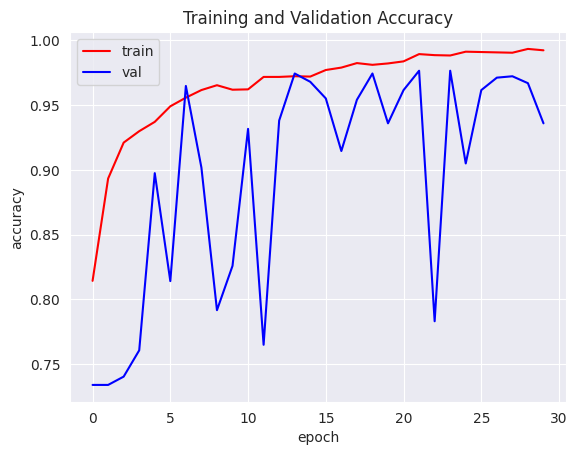

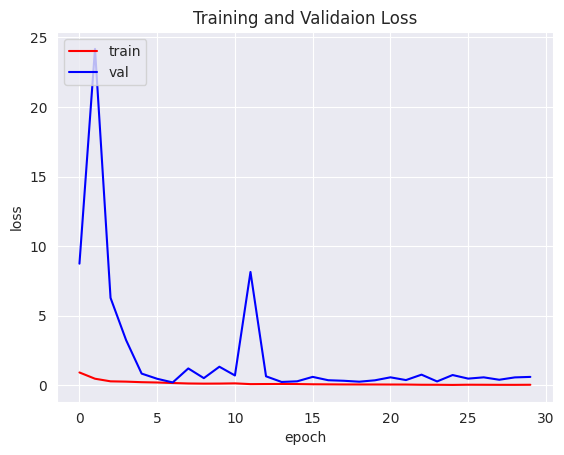

In [70]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

Grafik pertama menunjukkan akurasi data train (garis merah) dan akurasi data validation (garis biru) dari model selama setiap epoch. Kedua metrik ini memberikan gambaran tentang kinerja model. Idealnya, kita ingin melihat kedua garis ini bergerak naik seiring waktu, menunjukkan peningkatan akurasi baik pada data pelatihan maupun data validasi.

Grafik kedua menunjukkan nilai loss pelatihan (garis merah) dan loss validasi (garis biru) dari model selama setiap epoch. Loss adalah ukuran seberapa tidak akurat model dalam memprediksi label kelas. Tujuan utama adalah meminimalkan kerugian. Idealnya, kedua garis akan menurun seiring waktu, menunjukkan penurunan kerugian, baik pada data pelatihan maupun data validasi.



              precision    recall  f1-score   support

      Normal     0.7954    0.9311    0.8579       334
   Pneumonia     0.9706    0.9045    0.9364       838

    accuracy                         0.9121      1172
   macro avg     0.8830    0.9178    0.8972      1172
weighted avg     0.9206    0.9121    0.9140      1172



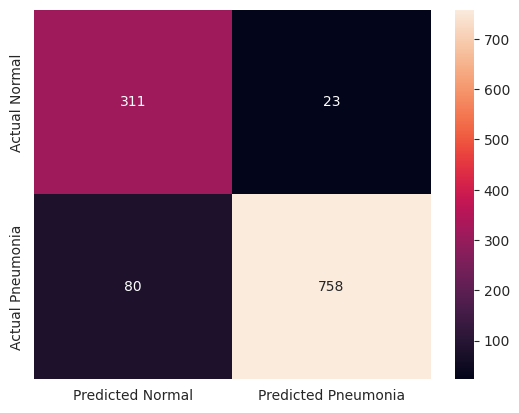

In [71]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Normal','Pneumonia'], digits=4))